# Modèle 2 – Données Emploi + Géographie
Ce notebook effectue l'entraînement de plusieurs modèles de régression sur les données enrichies issues des fichiers emploi + géographie.

In [1]:
import pandas as pd

# 1. Chargement
learn = pd.read_csv("learn_dataset.csv", sep=";")
job = pd.read_csv("learn_dataset_job.csv", sep=";")
geo = pd.read_csv("geographie.csv", sep=",")

# 2. Fusion finale
df = learn.merge(job, on="UNIQUE_ID", how="left")
df = df.merge(geo, on="insee_code", how="left")


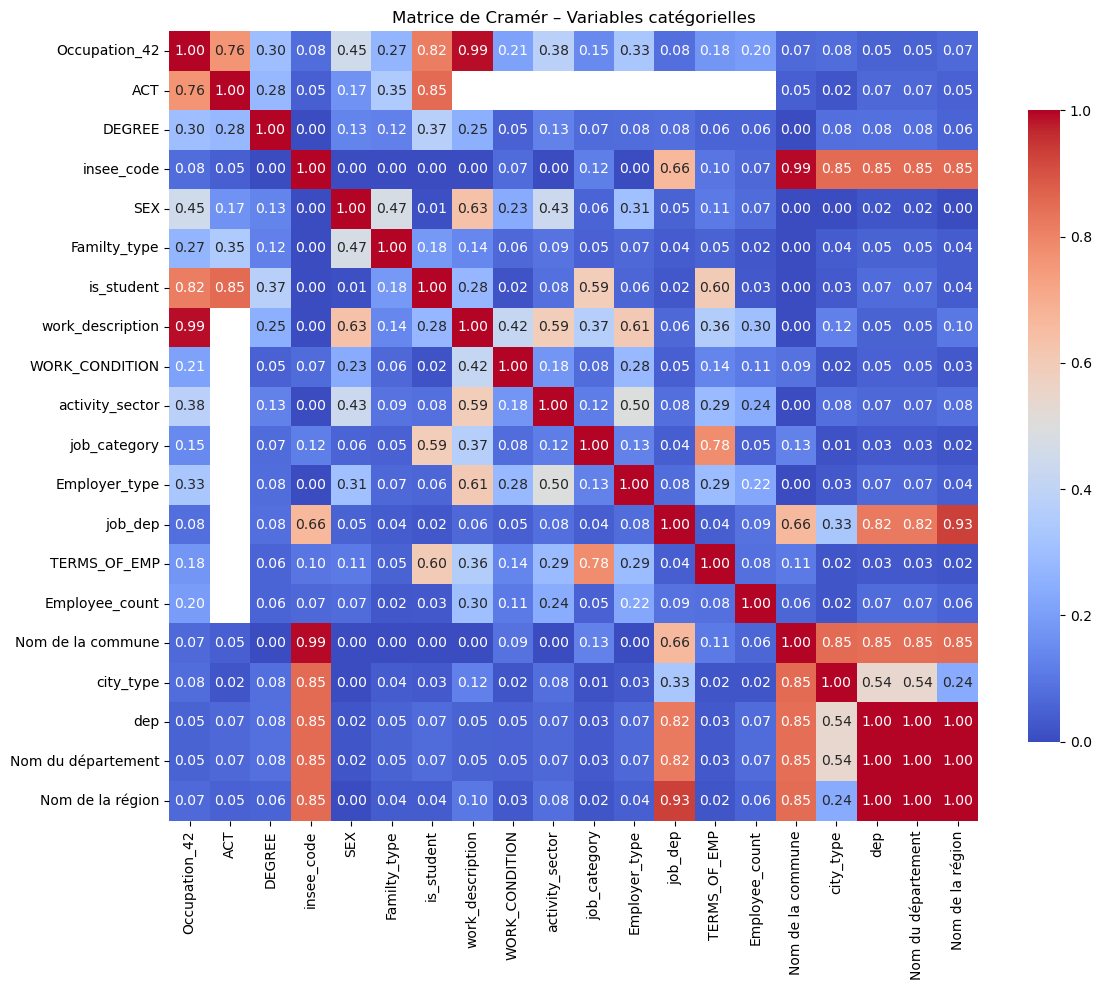

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# -----------------------------
# 1. Chargement et fusion déjà existants
# -----------------------------
learn = pd.read_csv("learn_dataset.csv", sep=";")
job   = pd.read_csv("learn_dataset_job.csv", sep=";")
geo   = pd.read_csv("geographie.csv", sep=",")

df = learn.merge(job, on="UNIQUE_ID", how="left")
df = df.merge(geo, on="insee_code", how="left")

# -----------------------------
# 2. Calcul de la matrice de Cramér
# -----------------------------
def cramers_v(x, y):
    """
    Calcule le coefficient de Cramér entre deux séries pandas (catégorielles).
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Correction de biais
    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    r_corr = r - ((r - 1)**2) / (n - 1)
    k_corr = k - ((k - 1)**2) / (n - 1)
    if min(k_corr - 1, r_corr - 1) <= 0:
        return np.nan
    return np.sqrt(phi2_corr / min(k_corr - 1, r_corr - 1))


# Sélectionnez ici uniquement les colonnes catégorielles de `df`
# (ou bien listez manuellement celles que vous voulez comparer).
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Initialisation d’un DataFrame vide pour stocker les scores
cramer_mat = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

# Remplissage de la matrice
for i, col1 in enumerate(cat_cols):
    for j, col2 in enumerate(cat_cols):
        if i <= j:
            v = cramers_v(df[col1], df[col2])
            cramer_mat.loc[col1, col2] = v
            cramer_mat.loc[col2, col1] = v

# -----------------------------
# 3. Visualisation de la matrice de Cramér
# -----------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(cramer_mat, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .8})
plt.title("Matrice de Cramér – Variables catégorielles")
plt.tight_layout()
plt.show()


In [3]:
# Étape 1 : Séparation X / y
X = df.drop(columns=["UNIQUE_ID", "target", "Nom de la région", "Nom du département", "insee_code", "nom_commune"], errors="ignore")
y = df["target"]

# Étape 2 : Préparation des colonnes
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

# Pipeline de traitement
preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

In [4]:
# Entraînement des modèles
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Découpage train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des modèles à tester
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Dictionnaire des résultats
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results[name] = {
        "R²": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred)
    }

In [5]:
!pip install xgboost

,R²,MAE,MSE
Linear Regression,0.926219,2.627328,12.039910
Random Forest,0.884802,3.169392,18.798594
XGBoost,0.940131,2.306354,9.769681


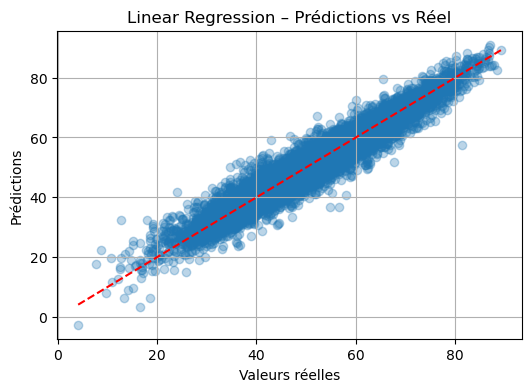

In [ ]:
# Évaluation des performances
import pandas as pd
import matplotlib.pyplot as plt

# Résumé des scores
results_df = pd.DataFrame(results).T
display(results_df)

# Visualisation des prédictions
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("model", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f"{name} – Prédictions vs Réel")
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Prédictions")
    plt.grid()
    plt.show()